# install necessary lib

In [242]:
!pip install -r requirements.txt

You should consider upgrading via the '/Users/jirayuwat/Desktop/GAN-indiv-study/env/bin/python3 -m pip install --upgrade pip' command.


# import lib

In [243]:
import torch
from torch import nn

from torchsummary import summary
from torchvision import transforms, datasets

from tqdm import tqdm

import matplotlib.pyplot as plt

import random

import numpy as np

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# load data

- load as data loader 
- batch size = 128
- image pixel value [0,1]
- only 1 channel

In [244]:
SEED = 1
BATCH_SIZE = 128
TEST_BATCH_SIZE = 128
torch.manual_seed(SEED)
train_loader = torch.utils.data.DataLoader (datasets.MNIST('../dataset/', 
                                                           train=True, 
                                                           download=True,
                                                           transform= transforms.Compose([transforms.ToTensor()])
                                                           ),
                                            batch_size = BATCH_SIZE, 
                                            shuffle=True)

test_loader = torch.utils.data.DataLoader(datasets.MNIST('../dataset/', 
                                                         train=False, 
                                                         transform=transforms.Compose([transforms.ToTensor()])
                                                        ), 
                                          batch_size = TEST_BATCH_SIZE, 
                                          shuffle=True)

tensor(0.) tensor(1.)
tensor(0.) tensor(0.9961)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)


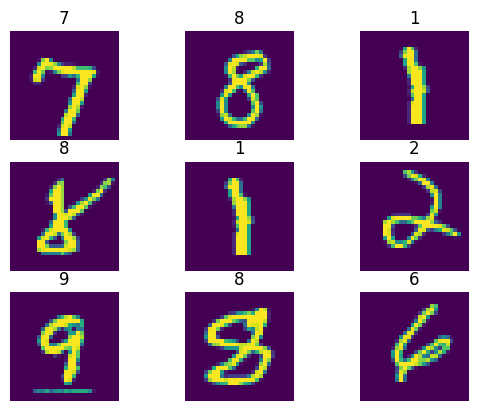

In [245]:
img, label = next(iter(train_loader))
import random
for i in range(9):
    idx = random.randint(0,63)
    plt.subplot(3, 3, i+1)
    plt.imshow(img[idx].reshape(28,28,1))
    plt.axis('off')
    plt.title(label[idx].item())
    print(torch.min(img[idx]), torch.max(img[idx]))


# Train controller

In [246]:
ITER = 5
TRAIN_AE = True
TRAIN_VAE = False


LATENT_SIZE = 10
IMAGE_SIZE = (1, 28, 28)

# create AE model
- latent = 20d
- 60 epoch
- optimizer = Adam
- loss = MSE
```
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
           Flatten-1                  [-1, 784]               0
              ReLU-2                  [-1, 784]               0
            Linear-3                 [-1, 1000]         785,000
              ReLU-4                 [-1, 1000]               0
            Linear-5                 [-1, 1000]       1,001,000
              ReLU-6                 [-1, 1000]               0
            Linear-7                 [-1, 1000]       1,001,000
              ReLU-8                 [-1, 1000]               0
            Linear-9                   [-1, 20]          20,020
           Linear-10                 [-1, 1000]          21,000
             ReLU-11                 [-1, 1000]               0
           Linear-12                 [-1, 1000]       1,001,000
             ReLU-13                 [-1, 1000]               0
           Linear-14                 [-1, 1000]       1,001,000
             ReLU-15                 [-1, 1000]               0
           Linear-16                  [-1, 784]         784,784
             ReLU-17                  [-1, 784]               0
        Unflatten-18            [-1, 1, 28, 28]               0
          Sigmoid-19            [-1, 1, 28, 28]               0
================================================================
Total params: 5,614,804
```
![result image](./AE_60epochs_20d-latent.png)

In [247]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0)

class AE_model(nn.Module):
    
    def __init__(self, latent_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.ReLU(),
            nn.Linear(IMAGE_SIZE[0] * IMAGE_SIZE[1] * IMAGE_SIZE[2], 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, latent_size)
        ).to(DEVICE)
        self.encoder.apply(init_weights)

        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, IMAGE_SIZE[0] * IMAGE_SIZE[1] * IMAGE_SIZE[2]),
            nn.ReLU(),
            nn.Unflatten(1, IMAGE_SIZE),
            nn.Sigmoid(),
        ).to(DEVICE)
        self.decoder.apply(init_weights)
    
    def forward(self, x_in):
        
        x_in = self.encoder(x_in)
        x_in = self.decoder(x_in)

        return x_in
    
summary(AE_model(LATENT_SIZE), IMAGE_SIZE)

ae_model = AE_model(LATENT_SIZE).to(DEVICE)
ae_loss_fn = nn.MSELoss()

ae_optimizer = torch.optim.Adam(params=ae_model.parameters(), lr = 5e-5)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
              ReLU-2                  [-1, 784]               0
            Linear-3                 [-1, 1000]         785,000
              ReLU-4                 [-1, 1000]               0
            Linear-5                 [-1, 1000]       1,001,000
              ReLU-6                 [-1, 1000]               0
            Linear-7                 [-1, 1000]       1,001,000
              ReLU-8                 [-1, 1000]               0
            Linear-9                   [-1, 10]          10,010
           Linear-10                 [-1, 1000]          11,000
             ReLU-11                 [-1, 1000]               0
           Linear-12                 [-1, 1000]       1,001,000
             ReLU-13                 [-1, 1000]               0
           Linear-14                 [-

/var/folders/5g/160h3py942nb4pbbgy0dhtz40000gn/T/ipykernel_30415/2049343008.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


## train model

In [248]:
EPOCHS = ITER if TRAIN_AE else 0

for epoch in range(EPOCHS):
    epoch += 1
    for batch_idx, (x_train, y_train) in enumerate(train_loader):
        x_train = x_train.to(DEVICE)
        y_train = y_train.to(DEVICE)
        
        ae_model.train()
        x_pred = ae_model(x_train)
        loss = ae_loss_fn(x_pred, x_train)
        ae_optimizer.zero_grad()
        loss.backward()
        ae_optimizer.step()

        ae_model.eval()
        with torch.inference_mode():
            if batch_idx % 10 == 0:
                print(f'Epoch: {epoch}/{EPOCHS}({batch_idx})\t: Loss = {loss.item()}')
                


Epoch: 1/5(0)	: Loss = 0.2323371022939682
Epoch: 1/5(10)	: Loss = 0.23095543682575226
Epoch: 1/5(20)	: Loss = 0.23095588386058807
Epoch: 1/5(30)	: Loss = 0.23201286792755127
Epoch: 1/5(40)	: Loss = 0.2301420271396637
Epoch: 1/5(50)	: Loss = 0.23144042491912842
Epoch: 1/5(60)	: Loss = 0.2313351184129715
Epoch: 1/5(70)	: Loss = 0.23127391934394836
Epoch: 1/5(80)	: Loss = 0.2313949018716812
Epoch: 1/5(90)	: Loss = 0.2316451221704483
Epoch: 1/5(100)	: Loss = 0.23199895024299622
Epoch: 1/5(110)	: Loss = 0.23121917247772217
Epoch: 1/5(120)	: Loss = 0.231114000082016
Epoch: 1/5(130)	: Loss = 0.23109085857868195
Epoch: 1/5(140)	: Loss = 0.23070146143436432
Epoch: 1/5(150)	: Loss = 0.2301531881093979
Epoch: 1/5(160)	: Loss = 0.22950342297554016
Epoch: 1/5(170)	: Loss = 0.2301895171403885
Epoch: 1/5(180)	: Loss = 0.22941061854362488
Epoch: 1/5(190)	: Loss = 0.22825318574905396
Epoch: 1/5(200)	: Loss = 0.22889931499958038
Epoch: 1/5(210)	: Loss = 0.22854098677635193
Epoch: 1/5(220)	: Loss = 0.227

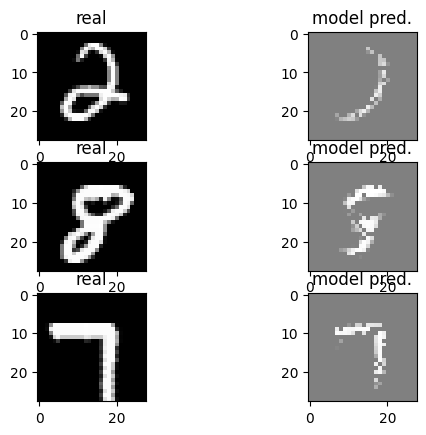

In [249]:
img, _ = next(iter(train_loader))
img = img.to(DEVICE)

for i in range(3):
    idx = random.randint(0, BATCH_SIZE - 1)
    x_pred = ae_model(img[idx]).to('cpu').detach().numpy().reshape((28, 28, 1))
    plt.subplot(3, 2, i*2 + 1)
    plt.title('real')
    plt.imshow(img[idx].to('cpu').reshape(28, 28, 1), vmin=0, vmax=1, cmap='gray')
    plt.subplot(3, 2, i*2 + 2)
    plt.title('model pred.')
    plt.imshow(x_pred, vmin=0, vmax=1, cmap='gray')
    if EPOCHS != 0:
        plt.savefig(f'AE_{EPOCHS}epochs_{LATENT_SIZE}d-latent.png')

# create VAE model

- ref vdo : [youtube](https://www.youtube.com/watch?v=VELQT1-hILo)
- ref paper : [arxiv](https://arxiv.org/abs/1312.6114)
- loss = `BCEloss`
- lr = `1e-4`
```
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Linear-1                  [-1, 200]         157,000
              ReLU-2                  [-1, 200]               0
            Linear-3                   [-1, 20]           4,020
            Linear-4                   [-1, 20]           4,020
            Linear-5                  [-1, 200]           4,200
              ReLU-6                  [-1, 200]               0
            Linear-7                  [-1, 784]         157,584
================================================================
Total params: 326,824
Trainable params: 326,824
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.25
Estimated Total Size (MB): 1.26
----------------------------------------------------------------
```

![image](AEV_60epochs_20d-latent.png)


In [250]:
class VAE_model(nn.Module):
    def __init__(self, image_size : tuple, latent_size : int = 20):
        super().__init__()

        # set var
        self.image_size = image_size
        self.pixel_num = image_size[0] * image_size[1] * image_size[2]

        # encoder
        self.input_2_hidden = nn.Linear(self.pixel_num, 200)
        self.hidden_2_mu = nn.Linear(200, latent_size)
        self.hidden_2_sigma = nn.Linear(200, latent_size)

        # decoder
        self.code_2_hidden = nn.Linear(latent_size, 200)
        self.hidden_2_output = nn.Linear(200, self.pixel_num)

        # activation function
        self.relu = nn.ReLU()


    def encode(self, x_in):
        ''' 
        encode the image
            input : image size equal to the configs
            output : mu, sigma 
        '''
        x_in = x_in.reshape(-1, self.pixel_num)
        hidden = self.relu(self.input_2_hidden(x_in))
        mu, sigma = self.hidden_2_mu(hidden), self.hidden_2_sigma(hidden)

        return mu, sigma

    def decode(self, code):
        '''
        decode from code to image
            input : code from latent space
            output : image generated from code
        '''

        hidden = self.relu(self.code_2_hidden(code))
        img = torch.reshape(self.hidden_2_output(hidden), (-1, self.image_size[0], self.image_size[1], self.image_size[2]))
        img = torch.sigmoid(img)

        return img

    def forward(self, x_in):
        # compute code
        mu, sigma = self.encode(x_in=x_in)
        epsilon = torch.rand_like(sigma)
        code = mu + sigma*epsilon

        # generate image from code
        x_recon = self.decode(code=code)
        
        return x_recon, mu, sigma
    
summary(VAE_model(IMAGE_SIZE, LATENT_SIZE), IMAGE_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]         157,000
              ReLU-2                  [-1, 200]               0
            Linear-3                   [-1, 10]           2,010
            Linear-4                   [-1, 10]           2,010
            Linear-5                  [-1, 200]           2,200
              ReLU-6                  [-1, 200]               0
            Linear-7                  [-1, 784]         157,584
Total params: 320,804
Trainable params: 320,804
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.22
Estimated Total Size (MB): 1.24
----------------------------------------------------------------


In [251]:
vae_model = VAE_model(image_size=IMAGE_SIZE,
                      latent_size=LATENT_SIZE)

vae_optimizer = torch.optim.Adam(params=vae_model.parameters(),
                                 lr=1e-4)
vae_loss_function = nn.BCELoss(reduction='sum')


## train model

In [252]:
EPOCHS = ITER if TRAIN_VAE else 0

for epoch in range(EPOCHS):
    loop = tqdm(enumerate(train_loader), desc=f'Epoch : {epoch}/{EPOCHS}')
    for batch_idx, (x_train, y_train) in loop:
        vae_model.train()
        
        x_recon, mu, sigma = vae_model(x_train)
        
        recon_loss = vae_loss_function(x_recon, x_train)
        kl_div = - torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
        loss = recon_loss + kl_div

        vae_optimizer.zero_grad()

        loss.backward()

        vae_optimizer.step()

        loop.set_postfix(loss=loss.item())


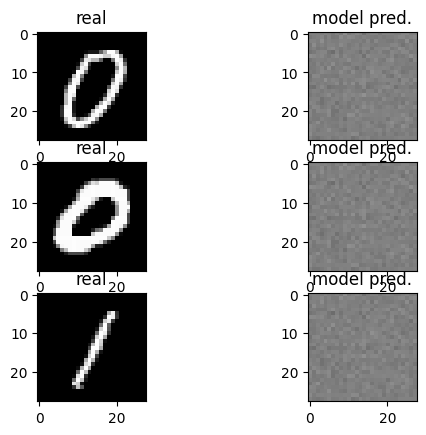

In [253]:
img, _ = next(iter(train_loader))
img = img.to(DEVICE)

for i in range(3):
    idx = random.randint(0, BATCH_SIZE - 1)
    x_pred = vae_model(img[idx])[0].to('cpu').detach().numpy().reshape((28, 28, 1))
    plt.subplot(3, 2, i*2 + 1)
    plt.title('real')
    plt.imshow(img[idx].to('cpu').reshape(28, 28, 1), vmin=0, vmax=1, cmap='gray')
    plt.subplot(3, 2, i*2 + 2)
    plt.title('model pred.')
    plt.imshow(x_pred, vmin=0, vmax=1, cmap='gray')
    if EPOCHS != 0:
        plt.savefig(f'AEV_{EPOCHS}epochs_{LATENT_SIZE}d-latent.png')


## test generate image

In [254]:
if LATENT_SIZE != 2:
    raise ValueError(f'Latent space dim must be 2')

img = np.zeros((1000,1000), dtype=np.float32)

inter_img_size = 28//2
for i in range(1000//inter_img_size):
    for j in range(1000//inter_img_size):
        
        mu = float(i - 500//inter_img_size) / (500//inter_img_size)
        sigma = float(j - 500//inter_img_size) / (500//inter_img_size)
        
        code = torch.rand((LATENT_SIZE))*sigma + mu

        decode_img = vae_model.decode(code).detach().numpy()[0, 0, ::28//inter_img_size, ::28//inter_img_size]

        start_i = inter_img_size*i
        start_j = inter_img_size*j
        img[start_i:start_i+inter_img_size, start_j:start_j+inter_img_size] = decode_img

ValueError: Latent space dim must be 2

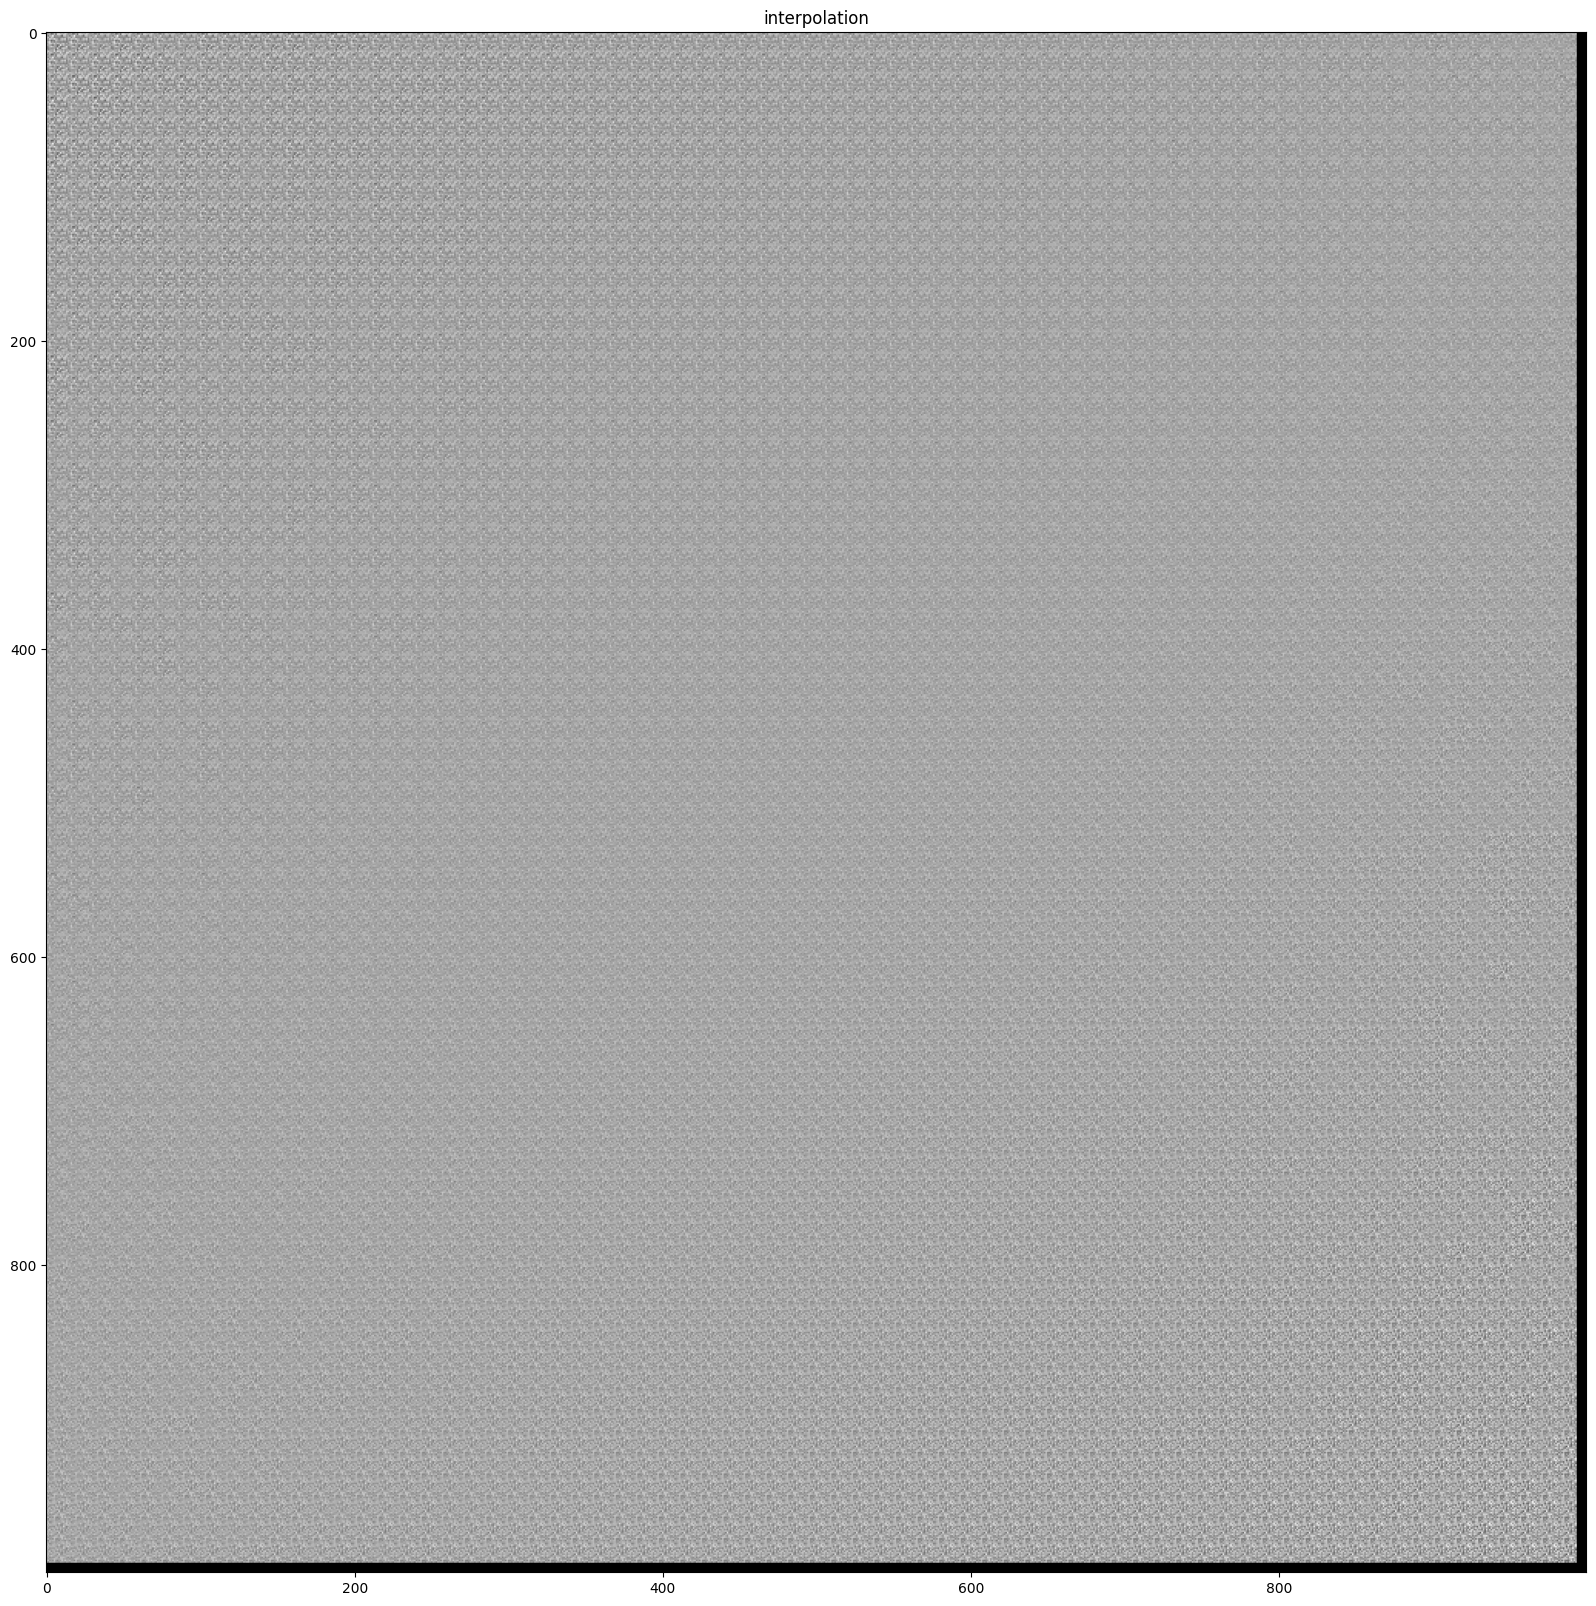

In [ ]:

plt.figure(figsize=(20, 20))
plt.title('interpolation')
plt.imshow(img, cmap='gray')